# Library Imports

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
%matplotlib inline

# Preprocessing (On a single example)
## Some helpful links:
* [Sound Wave Basics](https://dropsofai.com/sound-wave-basics-every-data-scientist-must-know-before-starting-analysis-on-audio-data/)
* [Understanding Audio Data and its Processing](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520)
* [What is a Sound Spectrum?](https://newt.phys.unsw.edu.au/jw/sound.spectrum.html)
* [Helpful Terminologies](https://dsp.stackexchange.com/questions/2426/terminology-spectrum-spectrogram-spectrograph-sonogram-etc)
* [Dummy's Guide to Mel-Frequency Cepstral Coefficients(MFCC)](https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd)

In [2]:
#path of the file
filename = 'UrbanSound8K/test_dog_bark.wav'

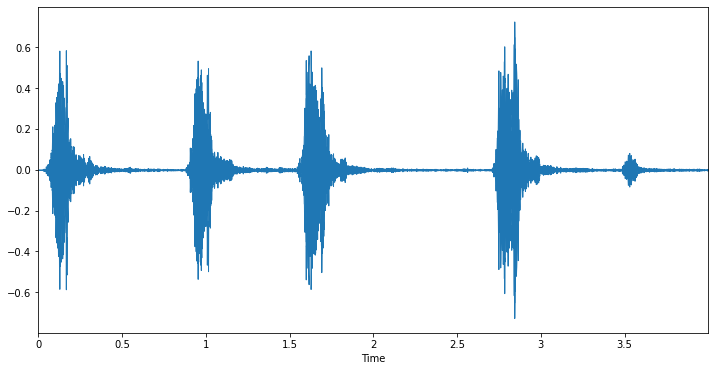

In [3]:
#plotting the audio in the test file as well as playing it out
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
data, sample_rate = librosa.load(filename)
librosa.display.waveplot(data, sr=sample_rate)
ipd.Audio(filename)

In [4]:
#extracting the mel-frequency cepstral coefficients
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)

In [5]:
#checking out the extracted features
mfccs

array([[-5.6826178e+02, -4.9177695e+02, -3.6617480e+02, ...,
        -5.0730090e+02, -5.1125122e+02, -5.1203552e+02],
       [ 4.3398777e+01,  1.1654913e+02,  1.7551927e+02, ...,
         9.0842979e+01,  9.3671539e+01,  9.6665298e+01],
       [ 2.1486229e+01,  3.9759567e+01, -5.0101795e+00, ...,
         2.7333738e+01,  2.8314140e+01,  3.1138660e+01],
       ...,
       [-5.1413026e+00, -4.9923801e+00,  4.4441810e+00, ...,
         2.7369027e+00,  1.1869838e+00, -4.8533142e-01],
       [-1.7783196e+00, -4.6503961e-01,  6.2187920e+00, ...,
         2.7966859e+00,  1.7500867e+00, -2.7275362e+00],
       [ 2.9700596e+00,  2.0405712e+00,  4.3179502e+00, ...,
         1.5787587e+00,  7.5013816e-01, -4.5062904e+00]], dtype=float32)

# Understanding what the variable 'mfccs' holds

In [6]:
#shape of the array that holds mfccs
mfccs.shape

(40, 173)

Here the dimension 0 represents the coefficients which we had asked for, 40 of them. The next dimension, i.e. dimension 1 represents each of those coefficents over a number of frames¹ throughout the entire signal. In this case 173 such frames. Obviously we can change this value by passing the required arguments.

¹A short slice of a time series used for analysis purposes. This usually corresponds to a single column of a spectrogram matrix. 

# Creating the Dataset

In [7]:
#path of dataset, metadata file
dataset_path = 'UrbanSound8K/audio'
metadata_path = 'UrbanSound8K/metadata/UrbanSound8K.csv'

In [8]:
#loading the metadata
metadata = pd.read_csv(metadata_path)
metadata.head(10)

slice_file_name    fsID      start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032   0.000000   0.317551         1     5        3   
1  100263-2-0-117.wav  100263  58.500000  62.500000         1     5        2   
2  100263-2-0-121.wav  100263  60.500000  64.500000         1     5        2   
3  100263-2-0-126.wav  100263  63.000000  67.000000         1     5        2   
4  100263-2-0-137.wav  100263  68.500000  72.500000         1     5        2   
5  100263-2-0-143.wav  100263  71.500000  75.500000         1     5        2   
6  100263-2-0-161.wav  100263  80.500000  84.500000         1     5        2   
7    100263-2-0-3.wav  100263   1.500000   5.500000         1     5        2   
8   100263-2-0-36.wav  100263  18.000000  22.000000         1     5        2   
9    100648-1-0-0.wav  100648   4.823402   5.471927         2    10        1   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  
5  children_playing  
6  children_playing  
7  children_playing  
8  children_playing  
9          car_horn

In [9]:
#defining the feature_extractor function
def feature_extractor(file, num_coeff):
    """
        feature_extractor allows to extract a given number of Mel-Frequency Cepstral Coefficients for the given file
        and returns it over averages of multiple frames.
        
        Parameters(s):
            file(str): A string representing the path/name of the file.
            num_coeff(int): An integer representing the number of coefficients to extract from the audio signal.
            
        Return(s):
            mfcc_features: Averaged num_coeff Mel-Frequency Cepstral Coefficients over multiple frames. 
    """
    audio_data, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=num_coeff)
    mfcc_features = np.mean(mfcc_features.T, axis=0)
    return mfcc_features

In [10]:
#extracting the MFCC features from each audio file
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file = os.path.join(os.path.abspath(dataset_path), 'fold'+str(row['fold'])+'/', str(row['slice_file_name']))
    class_label = row['class']
    features = list(feature_extractor(file, 40))
    features.append(class_label)
    extracted_features.append(features)

3554it [03:14, 19.23it/s]C:\Users\kanha\anaconda3\envs\mytfenv\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8324it [07:26, 25.08it/s]C:\Users\kanha\anaconda3\envs\mytfenv\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\kanha\anaconda3\envs\mytfenv\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [07:46, 18.72it/s]


In [11]:
#creating a dataframe to represent the dataset as extracted features and their class labels
col_names = [f'feature {i}' for i in range(1, 41)]
col_names.append('Class')
dataset = pd.DataFrame(extracted_features, columns=col_names)
dataset.head(10)

feature 1   feature 2   feature 3  feature 4  feature 5  feature 6  \
0 -215.793015   71.666122 -131.813766 -52.091328 -22.115967 -21.764179   
1 -424.686768  110.562271  -54.148235  62.010731  -0.709516  18.157396   
2 -459.564667  122.800354  -47.924709  53.265694  -1.139869  24.772371   
3 -414.553772  102.896904  -36.664951  54.180408   0.486004  15.697060   
4 -447.397003  115.095398  -53.809113  61.608585   1.642598  26.112864   
5 -447.708557  118.409454  -35.248665  56.739929   1.675178  26.060947   
6 -477.197205  120.637733  -29.692501  57.051910   1.102474  27.612000   
7 -464.846558  117.714539  -30.163269  50.722542  -5.693696  32.158348   
8 -472.121490  126.766006  -38.366531  58.748646  -2.761849  29.186029   
9 -196.185272  114.945061  -14.661183   1.229863 -20.730698  -4.206901   

   feature 7  feature 8  feature 9  feature 10  ...  feature 32  feature 33  \
0 -11.183746  18.912683   6.726638   14.556894  ...    7.130783   -0.079450   
1   1.445156  11.161131  -1.705890   12.360451  ...    1.641603   -0.784569   
2   7.980137   9.674258  -1.023544   11.204449  ...   -1.453565   -3.940218   
3   2.155129   8.104219  -2.487822   10.018102  ...    0.925128    1.110202   
4   1.995067  10.739072   2.596299   10.635984  ...   -1.488413   -0.228908   
5   5.176452  12.128124  -1.512035   10.201851  ...   -1.091389   -1.615298   
6   0.157535  12.427043  -1.890938   11.174763  ...   -0.280219   -3.014571   
7   6.367652  16.784801  -2.134644   13.725747  ...   -0.274989   -1.566593   
8   6.480686  13.917555   2.051260    8.705048  ...    0.641984    0.652038   
9 -40.966118   4.344552 -18.881565   -3.285731  ...   -0.808217   -2.278542   

   feature 34  feature 35  feature 36  feature 37  feature 38  feature 39  \
0    1.710924   -5.694199   -2.904172    3.036695   -1.682759   -0.885859   
1   -0.041276    0.039598   -0.094419   -1.656805    0.617409   -0.684974   
2   -2.184721   -1.456207   -1.697371   -1.492133    2.225414    1.546618   
3    0.869380   -2.226987    1.076617   -1.416407   -1.244889   -2.179443   
4    1.705498   -2.041438    0.061762   -0.778469    2.192595    1.005155   
5    0.295717   -0.268589   -1.639765   -0.660533   -0.152729    0.176656   
6    0.272442   -1.244779    1.705042   -0.840057    1.152155    1.237065   
7    1.812423   -2.186753   -0.687879   -0.651822   -1.650494   -2.529962   
8    0.001862    0.009379   -1.674842   -1.713372   -0.590332    0.085103   
9    4.033165   -7.085474   -4.795505   -1.718900    3.621345   -5.810403   

   feature 40             Class  
0    0.354389          dog_bark  
1    0.571514  children_playing  
2   -0.836316  children_playing  
3   -1.077177  children_playing  
4    0.191029  children_playing  
5   -1.845035  children_playing  
6   -0.253818  children_playing  
7    0.959766  children_playing  
8   -2.991671  children_playing  
9   -1.155214          car_horn  

[10 rows x 41 columns]

In [12]:
#path for saving dataset
feature_dataset_path = 'UrbanSound8K/dataset.csv'

In [13]:
#saving the dataset as csv as a checkpoint to avoid extracting the features again
dataset.to_csv(feature_dataset_path, index=False)

# Loading the Dataset with Audio Features and Preprocessing

In [14]:
#loading the dataset
dataset = pd.read_csv(feature_dataset_path)
dataset.head(10)

feature 1   feature 2   feature 3  feature 4  feature 5  feature 6  \
0 -215.793015   71.666122 -131.813766 -52.091328 -22.115967 -21.764179   
1 -424.686768  110.562271  -54.148235  62.010731  -0.709516  18.157396   
2 -459.564667  122.800354  -47.924709  53.265694  -1.139869  24.772371   
3 -414.553772  102.896904  -36.664951  54.180408   0.486004  15.697060   
4 -447.397003  115.095398  -53.809113  61.608585   1.642598  26.112864   
5 -447.708557  118.409454  -35.248665  56.739929   1.675178  26.060947   
6 -477.197205  120.637733  -29.692501  57.051910   1.102474  27.612000   
7 -464.846558  117.714539  -30.163269  50.722542  -5.693696  32.158348   
8 -472.121490  126.766006  -38.366531  58.748646  -2.761849  29.186029   
9 -196.185272  114.945061  -14.661183   1.229863 -20.730698  -4.206901   

   feature 7  feature 8  feature 9  feature 10  ...  feature 32  feature 33  \
0 -11.183746  18.912683   6.726638   14.556894  ...    7.130783   -0.079450   
1   1.445156  11.161131  -1.705890   12.360451  ...    1.641603   -0.784569   
2   7.980137   9.674258  -1.023544   11.204449  ...   -1.453565   -3.940218   
3   2.155129   8.104219  -2.487822   10.018102  ...    0.925128    1.110202   
4   1.995067  10.739072   2.596299   10.635984  ...   -1.488413   -0.228908   
5   5.176452  12.128124  -1.512035   10.201851  ...   -1.091389   -1.615298   
6   0.157535  12.427043  -1.890938   11.174763  ...   -0.280219   -3.014571   
7   6.367652  16.784801  -2.134644   13.725747  ...   -0.274989   -1.566593   
8   6.480686  13.917555   2.051260    8.705048  ...    0.641984    0.652038   
9 -40.966118   4.344552 -18.881565   -3.285731  ...   -0.808217   -2.278542   

   feature 34  feature 35  feature 36  feature 37  feature 38  feature 39  \
0    1.710924   -5.694199   -2.904172    3.036695   -1.682759   -0.885859   
1   -0.041276    0.039598   -0.094419   -1.656805    0.617409   -0.684974   
2   -2.184721   -1.456207   -1.697371   -1.492133    2.225414    1.546618   
3    0.869380   -2.226987    1.076617   -1.416407   -1.244889   -2.179443   
4    1.705498   -2.041438    0.061762   -0.778469    2.192595    1.005155   
5    0.295717   -0.268589   -1.639765   -0.660533   -0.152729    0.176656   
6    0.272442   -1.244779    1.705042   -0.840057    1.152155    1.237065   
7    1.812423   -2.186753   -0.687879   -0.651822   -1.650494   -2.529962   
8    0.001862    0.009379   -1.674842   -1.713372   -0.590332    0.085103   
9    4.033165   -7.085474   -4.795505   -1.718900    3.621345   -5.810403   

   feature 40             Class  
0    0.354389          dog_bark  
1    0.571514  children_playing  
2   -0.836316  children_playing  
3   -1.077177  children_playing  
4    0.191029  children_playing  
5   -1.845035  children_playing  
6   -0.253818  children_playing  
7    0.959766  children_playing  
8   -2.991671  children_playing  
9   -1.155214          car_horn  

[10 rows x 41 columns]

In [15]:
#splitting into Independent and Dependent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [16]:
#checking out the splitted dataset
X.shape

(8732, 40)

In [17]:
#checking out the splitted dataset
y.shape

(8732,)

In [18]:
#one hot encoding the Dependent variable
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))

In [19]:
#checking out the shape and content of Dependent variable
y.shape

(8732, 10)

In [20]:
#checking out the shape and content of Dependent variable
y[0:5, :]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [21]:
#splitting the data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
#number of classes
num_classes = y.shape[1]

# Model Creation
We'll be creating the following model(s):
* Artificial Neural Network

In [23]:
#creating the architecture of model
ann = Sequential()
ann.add(Dense(100, activation='relu', input_shape=(40,)))
ann.add(Dropout(0.5))
ann.add(Dense(200, activation='relu'))
ann.add(Dropout(0.5))
ann.add(Dense(100, activation='relu'))
ann.add(Dropout(0.5))
ann.add(Dense(num_classes, activation='softmax'))
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1

In [24]:
#compiling the ann model
ann.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [25]:
#training the ann model
num_epochs = 100
batch_size = 32
save_path = 'saved_models/audio_classification_{epoch:02d}_{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=save_path, verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
callbacks = [checkpoint]
ann.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
197/219 [=========================>....] - ETA: 0s - loss: 10.9652 - accuracy: 0.1171
Epoch 00001: val_accuracy improved from -inf to 0.09960, saving model to saved_models\audio_classification_01_0.10.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 10.1819 - accuracy: 0.1188 - val_loss: 2.2871 - val_accuracy: 0.0996
Epoch 2/100
195/219 [=========================>....] - ETA: 0s - loss: 2.5657 - accuracy: 0.1135
Epoch 00002: val_accuracy improved from 0.09960 to 0.11849, saving model to saved_models\audio_classification_02_0.12.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 2.5443 - accuracy: 0.1141 - val_loss: 2.2756 - val_accuracy: 0.1185
Epoch 3/100
214/219 [============================>.] - ETA: 0s - loss: 2.3280 - accuracy: 0.1209
Epoch 00003: val_accuracy improved from 0.11849 to 0.12536, saving model to saved_models\audio_classification_03_0.13.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 2.3275 - accurac

Epoch 25/100
213/219 [============================>.] - ETA: 0s - loss: 1.4534 - accuracy: 0.4977
Epoch 00025: val_accuracy improved from 0.58786 to 0.60504, saving model to saved_models\audio_classification_25_0.61.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 1.4525 - accuracy: 0.4981 - val_loss: 1.2488 - val_accuracy: 0.6050
Epoch 26/100
218/219 [============================>.] - ETA: 0s - loss: 1.4540 - accuracy: 0.4908
Epoch 00026: val_accuracy did not improve from 0.60504
219/219 [==============================] - 1s 2ms/step - loss: 1.4539 - accuracy: 0.4911 - val_loss: 1.2492 - val_accuracy: 0.5999
Epoch 27/100
210/219 [===========================>..] - ETA: 0s - loss: 1.4262 - accuracy: 0.5110
Epoch 00027: val_accuracy did not improve from 0.60504
219/219 [==============================] - 0s 2ms/step - loss: 1.4246 - accuracy: 0.5107 - val_loss: 1.2565 - val_accuracy: 0.5976
Epoch 28/100
203/219 [==========================>...] - ETA: 0s - loss: 1.3880 -

Epoch 77/100
212/219 [============================>.] - ETA: 0s - loss: 0.9704 - accuracy: 0.6742
Epoch 00077: val_accuracy did not improve from 0.75673
219/219 [==============================] - 1s 3ms/step - loss: 0.9715 - accuracy: 0.6740 - val_loss: 0.7977 - val_accuracy: 0.7459
Epoch 78/100
211/219 [===========================>..] - ETA: 0s - loss: 0.9850 - accuracy: 0.6714
Epoch 00078: val_accuracy did not improve from 0.75673
219/219 [==============================] - 0s 2ms/step - loss: 0.9862 - accuracy: 0.6717 - val_loss: 0.7907 - val_accuracy: 0.7459
Epoch 79/100
216/219 [============================>.] - ETA: 0s - loss: 0.9659 - accuracy: 0.6746
Epoch 00079: val_accuracy did not improve from 0.75673
219/219 [==============================] - 0s 2ms/step - loss: 0.9662 - accuracy: 0.6744 - val_loss: 0.7629 - val_accuracy: 0.7516
Epoch 80/100
200/219 [==========================>...] - ETA: 0s - loss: 0.9867 - accuracy: 0.6720
Epoch 00080: val_accuracy did not improve from 0.7

In [26]:
#model validation accuracy
acc = ann.evaluate(X_test, y_test, verbose=0)
acc[1]

0.7521465420722961

# Checking out Model Predictions
We'll be checking out predictions manually for the following five classes:
* Air Conditioner
* Car Honk
* Children Playing
* Dog Bark
* Street Music

In [27]:
#loading the test file paths
air_cond_path = 'UrbanSound8K/test_air_conditioner.wav'
car_honk_path = 'UrbanSound8K/test_car_honk.wav'
children_playing_path = 'UrbanSound8K/test_children_playing.wav'
dog_bark_path = 'UrbanSound8K/test_dog_bark.wav'
street_music_path = 'UrbanSound8K/test_street_music.wav'

In [28]:
#air conditioner class
ipd.Audio(air_cond_path)

In [29]:
#testing prediction for air conditioner class
air_cond, sample_rate = librosa.load(air_cond_path)
air_cond = librosa.feature.mfcc(y=air_cond, sr=sample_rate, n_mfcc=40)
air_cond = np.mean(air_cond.T, axis=0)
air_cond = air_cond.reshape(1, -1)
pred = ann.predict_classes(air_cond)
pred = le.inverse_transform(pred)
pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array(['air_conditioner'], dtype=object)

In [30]:
#car honk class
ipd.Audio(car_honk_path)

In [31]:
#testing prediction for car honk class
car_honk, sample_rate = librosa.load(car_honk_path)
car_honk = librosa.feature.mfcc(y=car_honk, sr=sample_rate, n_mfcc=40)
car_honk = np.mean(car_honk.T, axis=0)
car_honk = car_honk.reshape(1, -1)
pred = ann.predict_classes(car_honk)
pred = le.inverse_transform(pred)
pred

array(['dog_bark'], dtype=object)

In [32]:
#children playing class
ipd.Audio(children_playing_path)

In [33]:
#testing prediction for children playing class
children_playing, sample_rate = librosa.load(children_playing_path)
children_playing = librosa.feature.mfcc(y=children_playing, sr=sample_rate, n_mfcc=40)
children_playing = np.mean(children_playing.T, axis=0)
children_playing = children_playing.reshape(1, -1)
pred = ann.predict_classes(children_playing)
pred = le.inverse_transform(pred)
pred

array(['children_playing'], dtype=object)

In [34]:
#dog bark class
ipd.Audio(dog_bark_path)

In [35]:
#testing prediction for dog bark class
dog_bark, sample_rate = librosa.load(dog_bark_path)
dog_bark = librosa.feature.mfcc(y=dog_bark, sr=sample_rate, n_mfcc=40)
dog_bark = np.mean(dog_bark.T, axis=0)
dog_bark = dog_bark.reshape(1, -1)
pred = ann.predict_classes(dog_bark)
pred = le.inverse_transform(pred)
pred

array(['dog_bark'], dtype=object)

In [36]:
#street music class
ipd.Audio(street_music_path)

In [37]:
#testing prediction for street music class
street_music, sample_rate = librosa.load(street_music_path)
street_music = librosa.feature.mfcc(y=street_music, sr=sample_rate, n_mfcc=40)
street_music = np.mean(street_music.T, axis=0)
street_music = street_music.reshape(1, -1)
pred = ann.predict_classes(street_music)
pred = le.inverse_transform(pred)
pred

array(['street_music'], dtype=object)

# Closing Note
We can further improve the accuracy by creating a better architecture and exploring feature extraction techniques other than Mel-Frequency Cepstrum Coefficients. Hyperparameter tuning can also give a small boost towards improving our results. 